# KDE Dataset Generation

*Version 1.0.3*

## Purpose

The purpose of this project is to generate a new dataset from an original dataset. The new dataset can be smaller and/or bigger than the original one. Also, the new dataset must be equivalent to the original one, which means that the original information must be kept in the new one.

We assume that the dataset "essence" is contained in the attributes and categories distributions, so we will estimate `Probability Density Functions` (`PDFs`) from the original dataset using `Kernel Density Estimation` (`KDE`). The new dataset will be built from the original `PDFs`.

## Test Dataset Generation

We will build a custom dataset to simplify the analysis, development and testing. This dataset will be considered as the original.

We need a dataset with only one attribute and two categories. Also, the attribute distributions grouped by each category must show a little overlap between them.

We will generate the custom dataset with 200 instances (100 instances per category).

Finally, we will plot the dataset distribution per category. **(Figure 1)**

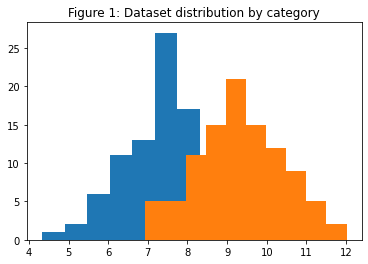

In [1]:
import dataset

# Dataset params
size = 200
n_features = 1
n_categories = 2
seed = 8

# Generate df
df = dataset.generate_dataset(size, n_features, n_categories, seed)

# Plot df
title = "Figure 1: Dataset distribution by category"
dataset.histogram(title, df)


Looking at the chart we can conclude that the custom dataset was properly generated. We can even see the little overlap between distributions.

## KDEs

We need to get the `KDEs` from the dataset distributions to estimate `PDFs`.

We will always generate as many `KDEs` as categories are. We will take instances associated to a specific category and build the `KDE` from them. Each instance will keep all the attributes, that means `KDEs` are multidimensional (one dimension per attribute).

For this case, we will calculate two `KDEs` (1 for category `0`, 1 for category `1`).

In [2]:
import kde 

# Caculate KDEs
kdes = kde.kdes(df)

To make sure `PDFs` estimation are right, we will plot the dataset distributions using the previous calculated `KDEs`. **(Figure 2)**

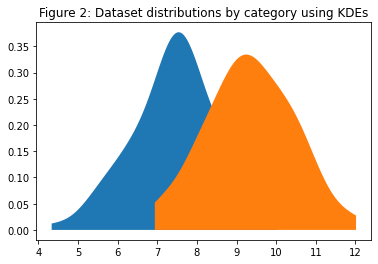

In [3]:
title = "Figure 2: Dataset distributions by category using KDEs"
kde.plot_2d(title, df, kdes)

The distributions represented in the charts are the same, so we conclude that `KDEs` are right.

## First Method

To build the new dataset this method will generate instances randomly and label the new instances using previous `KDEs`.

The possible attributes values of each instance must be contained in intervals (one interval per attribute) which have been calculated from the original values of the attributes.

Once a new instance is generated we will estimate its density using each `KDE`. We will set the label associated to the `KDE` that gives biggest density. We will repeat this process until reach the amount of instances per category which have been defined previously. Instances associate to a category which is full will be discard.

The minimun amount of instances per category is a parameter which depends of the dataset. To optimize this parameter we will need an another study. We will test different values until getting a value that allows to describe correctly each category distribution. We will check it comparing the charts.

We are going to define attributes intervals.

In [4]:
# Get attributes ranges
attributes_ranges = dataset.attributes_ranges(df)

We are going to generate instances and label it until reach the target amount of new instances per category.

In [5]:
# Define amount of new instances per category
n_instances = 1000
# Build nw dataset
new_df = kde.random_generation(n_instances, kdes, attributes_ranges, df.columns, seed)

Now we will plot the new dataset distribution and compare it with the original dataset distributions. **(Figure 3)**

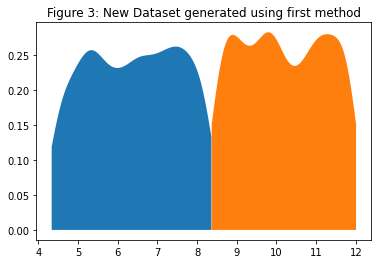

In [6]:
# Calculate new kdes of the new dataset
new_kdes = kde.kdes(new_df)

# Plot new dataset
title = "Figure 3: New Dataset generated using first method"
kde.plot_2d(title, new_df, new_kdes)

The new dataset distributions is significantly different.

We can see that the random instances are well labeled. But if we compare each distributions with the originals, we will see that are not the same.

The reason behind of these differences may be that this method gives the same probability of appearing to all attribute values but in the distributions some values must have more propability of appearing than others.

The current version of this method does not converge.

## Second Method

In this method, we will generate relevant instances for each distribution, we will estimate density (relevancy) for each instance and we will build a dataset which each relevant instance is correctly represented.

We will generate each distribution in a independant way. For each distribution, we will generate relevant instances which be called support. For each instance, we will estimate density using the original `KDE`. The chosen `KDE` will be the associated one to the distribution (groped by category) which is currently being proccesed. This density determines which instances are more significant according to the original distribution so we will build a dataset which more relevant instances will be more represented. To achieve this we will introduce more occurrences of the relevant instances.

There are different ways to generate the support. This topic would require a study to find an efficient method.

We are going to use an exhaustive method which consist in generaing instances to cover the whole distribution space. For example, in our dataset, the attribute interval for category `1` is [7,12] so we will generate equally spaced instances between 7 and 12.

The support adjustment to original distribution can be managed increasing or decreasing the amount of instances. We will call granularity to this parameter. To optimize the granularity we will need a specify study.

To build the support in multivariate dataset cases we will generate each attribute support with the above method and do a cartesian product between all attributes supports.

If we think about exahustive method in a practical way, we will take into account that this method has an unacceptable complexity. So we will need to design more efficient methods in the future.

We are going to generate the support.

In [7]:
# Define granularity
granularity = 100

# Generate supports
new_df = kde.univariate_support(df, granularity)

We are going to estimate density for each instance. We will use the original `KDEs` to achieve this.

In [8]:
# Calculate densities for each instance
densities = kde.estimate_density(new_df, kdes)

Now we know the density for each new instance. That means that we know the representation grade of each new instance according to the original dataset. The goal is to modify the new dataset to get a correct representation for each instance.

There are multiple ways to change instance representations in the dataset.

We are going to increase the amount of the same instance using its density. That means instances with higher density will be appear more than instances with lower density. We will link to the instance with lowest density to an amount of one instance. So, to calculate the amount of duplicate instances for each instance, we are going to divide the instance density between lowest density.

We can think that duplicates instances adding redundant information and so it is. But there is no problem because it is just a method of get the proper representation of the instances. On the other hand, granularity is managed by the instances amount in the support. Nevertheless, there are alternatives to manage instances represention which do not involve duplicate instances. For example, we can search instances neighbours and use them.

We are going to build the new dataset duplicating instances.

In [9]:
# Adjust instance representations in the new dataset
new_df = kde.adjust_representation(densities)

Finally, we are going to plot new dataset and compare it with original dataset. **(Figure 4)**

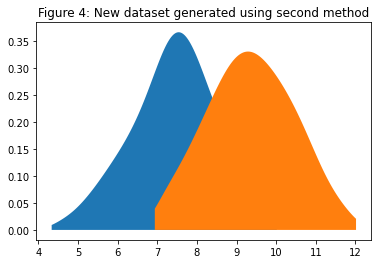

In [10]:
# Plot new df
title = "Figure 4: New dataset generated using second method"
new_kdes = kde.kdes(new_df)
kde.plot_2d(title, new_df, new_kdes)

If we compare the new dataset distributions with the original dataset distributions, we will see that they are the same so we can conclude that this method converges.

The new dataset size is about 2000 instances. The instances amount has increased significantly but it is not very important. This result is mainly due to the representation adjustment method used, which can easily change for another methods which can reduce the number of instances. Even if we can not find a method which give us a smaller dataset directly, we can design another `KDE` based method which can reduce dataset instances. For example, we can combine `KDE` with `MSE` to achieve this.

The most important part of the proposal method is that we can generate an equivalent dataset with different values compared to the original values.

## Multivariate Test Dataset Generation

We need to make sure that the behaviour of `Second Method` (our best proposal) is properly on `Multivariate Test Dataset`

We are going to generate a new dataset of 200 instances with 2 features and 2 categories.

Must exist a little overlap between distributions groped by categories.

We are going to plot the new dataset using an `Scatter Chart` and `3D Chart` to make sure we are generate the dataset properly.

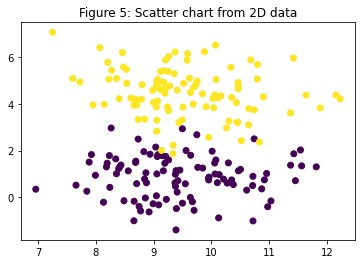

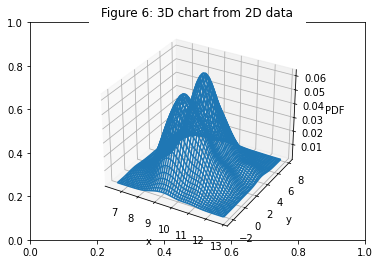

In [11]:
import dataset

# Dataset params
size = 200
n_features = 2
n_categories = 2
seed = 4

# Generate df
df = dataset.generate_dataset(size, n_features, n_categories, seed)

# Plot df
## Scatter Chart
title = "Figure 5: Scatter chart from 2D data"
dataset.scatter(title, df)
## 3D Chart
title = "Figure 6: 3D chart from 2D data"
kde.plot_3d(title, df)


Plot conclusion [WIP]

KDE [WIP]

In [12]:
# Get KDEs from 2D dataset
kdes = kde.kdes(df)

New dastaset [WIP]

In [13]:
# Define granularity
granularity = 100

# Generate new df
new_df = kde.multivariate_dataset(df, granularity)

Estimate densities [WIP]

In [14]:
# Calculate densities for each instance
new_df = kde.estimate_density(new_df, kdes)

In [15]:
# Adjust instance representations in the new dataset
new_df = kde.new_adjust_representation(new_df)
new_df

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

NameError: name 'exit' is not defined

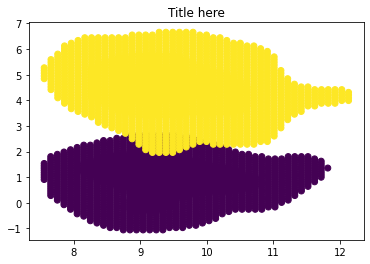

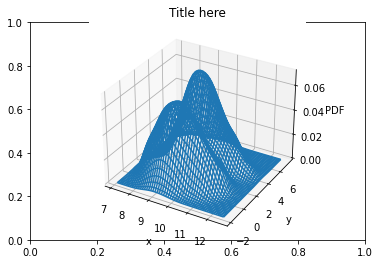

In [ ]:

# Plot dataset
## Scatter Chart
title = "Title here"
dataset.scatter(title, new_df)
## 3D Chart
title = "Title here"
kde.plot_3d(title, new_df)


## Future Changes

The original purpose is generate an equivalent dataset from the original dataset but with different values. For this, we will use `PDFs` which are estimated using `KDE`.

We are found a [book section](https://web.mit.edu/urban_or_book/www/book/chapter7/7.1.3.html) in which there are apparently at leat 4 methods to generate samples from a `PDF`. These methods would be able to more efficient than the second method so we will be interesting analyze them.